In [114]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

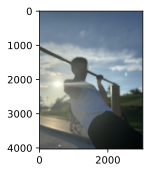

In [115]:
d2l.set_figsize()
content_img=d2l.Image.open('C:/Users/Administrator/Desktop/nb.jpg')
d2l.plt.imshow(content_img)

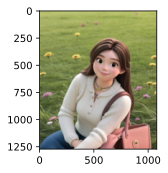

In [116]:
style_img=d2l.Image.open('C:/Users/Administrator/Desktop/橡皮.jpg')
d2l.plt.imshow(style_img)

In [117]:
#预处理和后处理
rgb_mean=torch.tensor([0.458,0.456,0.406])
rgb_std=torch.tensor([0.229,0.224,0.225])
def preprocess(img,image_shape):
    transforms=torchvision.transforms.Compose([torchvision.transforms.Resize(image_shape),
                                              torchvision.transforms.ToTensor(),
                                              torchvision.transforms.Normalize(mean=rgb_mean,std=rgb_std)])
    return transforms(img).unsqueeze(0)
# 后处理函数，将tensor转化为图片
def postprocess(img): # tensor变为图片
    # 将输入的tensor移动到与rgb_std相同的设备上
    img = img[0].to(rgb_std.device)
    # 反标准化处理：对img的每个像素乘以标准差并加上均值，并确保结果在[0,1]范围内
    img = torch.clamp(img.permute(1,2,0) * rgb_std + rgb_mean, 0, 1)
    # 将处理后的tensor转换为PIL图像，并返回
    return torchvision.transforms.ToPILImage()(img.permute(2,0,1))

In [118]:
pretrained_net=torchvision.models.vgg19(pretrained=True)
print(pretrained_net)
style_layers,content_layers=[0,5,10,19,28],[25]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

In [119]:
net=nn.Sequential(*[pretrained_net.features[i] for i in range(max(style_layers+content_layers)+1)])
print(net)
print(len(net))

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [120]:
def extract_features(X,content_layers,style_layers):
    contents=[]
    styles=[]
    for i in range(len(net)):
        X=net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents,styles
def get_contents(image_shape,device):
    content_X=preprocess(content_img,image_shape).to(device)
    content_Y,_=extract_features(content_X,content_layers,style_layers)
    return content_X,content_Y
def get_styles(image_shape,device):
    style_X=preprocess(style_img,image_shape).to(device)
    _,style_Y=extract_features(style_X,content_layers,style_layers)
    return style_X,style_Y

In [121]:
#定义损失函数
def content_loss(Y_hat,Y):
    return torch.square(Y_hat-Y.detach()).mean()
def gram(X):
    num_channels,n=X.shape[1],X.numel()//X.shape[1]
    X=X.reshape((num_channels,n))
    return torch.matmul(X,X.T)/(num_channels*n)
def style_loss(Y_hat,gram_Y):
    return torch.square(gram(Y_hat)-gram_Y.detach()).mean()
# 总变差损失函数，用于提高生成图像的空间连续性，以减少生成图像的高频噪声
def tv_loss(Y_hat):
    # 计算图像中相邻像素之间的差值的绝对值的平均值
    return 0.5 * (torch.abs(Y_hat[:,:,1:,:] - Y_hat[:,:,:-1,:]).mean()+
                 torch.abs(Y_hat[:,:,:,1:] - Y_hat[:,:,:,:-1]).mean())

In [122]:
content_weight,style_weight,tv_weight=1,1e3,10
def compute_loss(X,contents_Y_hat,styles_Y_hat,contents_Y,styles_Y):
    contents_l=[content_loss(Y_hat,Y)*content_weight for Y_hat,Y in zip(contents_Y_hat,contents_Y)]
    styles_l=[style_loss(Y_hat,Y)*style_weight for Y_hat,Y in zip(styles_Y_hat,styles_Y)]
    tv_l=tv_loss(X)*tv_weight
    l=sum(10*styles_l+contents_l+[tv_l]) #为什么加[],因为前面两个都是list形式
    return contents_l,styles_l,tv_l,l

In [123]:
#初始化合成图像
class SynthesizedImage(nn.Module):
    def __init__(self,image_shape,**kwargs):
        super(SynthesizedImage,self).__init__(**kwargs)
        self.weight=nn.Parameter(torch.rand(*image_shape))
    def forward(self):
        return self.weight
def get_inits(X,device,lr,styles_Y):
    gen_img=SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(),lr=lr)
    styles_Y_gram=[gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

In [124]:
# 训练模型
# 定义训练函数
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    # 初始化合成图像、样式特征的Gram矩阵和优化器
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    # 定义学习率调度器，每隔lr_decay_epoch个epoch，学习率乘以0.8
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)     
    # 创建一个动画展示器，用于展示每个epoch的内容损失、样式损失和TV损失
    animator = d2l.Animator(xlabel='epoch',ylabel='loss',xlim=[10,num_epochs], 
                           legend=['content','style','TV'],ncols=2,figsize=(7, 2.5))   
    # 对每个epoch
    for epoch in range(num_epochs):
        # 清零优化器的梯度
        trainer.zero_grad()
        # 提取合成图像的内容特征和样式特征
        contents_Y_hat, styles_Y_hat = extract_features(X, content_layers, style_layers)  
        # 计算内容损失、样式损失、TV损失和总损失
        contents_l, styles_l, tv_l, l = compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)  
        # 计算总损失的梯度
        l.backward()
        # 使用优化器更新合成图像的像素值
        trainer.step()
        # 更新学习率
        scheduler.step()
        # 每隔10个epoch，展示一次合成图像和各项损失
        if(epoch+1) % 10 == 0:
            # 在animator的第二个子图上显示当前生成的图像
            # postprocess函数将生成的图像从张量转换回PIL图像
            animator.axes[1].imshow(postprocess(X))
            # 在animator中添加当前epoch和对应的内容损失、风格损失和TV损失
            # sum函数用于计算所有元素的和，float函数将结果转换为浮点数
            animator.add(epoch + 1, 
                         [float(sum(contents_l)),
                         float(sum(styles_l)),
                         float(tv_l)])
    # 返回训练得到的合成图像
    return X

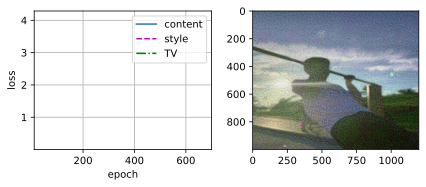

In [ ]:
# 训练模型
# 选择设备，如果有可用的GPU，就使用GPU，否则使用CPU
# image_shape定义了生成图像的形状，(300,450)代表生成的图像高为300，宽为450
device, image_shape = d2l.try_gpu(), (1000,1200)
# 将提取特征的模型移动到指定设备上
net = net.to(device)
# 对内容图像进行预处理，并提取其内容特征
content_X, contents_Y = get_contents(image_shape, device)
# 对样式图像进行预处理，并提取其样式特征
_, styles_Y = get_styles(image_shape, device)
# 训练模型，学习率为0.3，总共训练500个epoch，每50个epoch学习率衰减一次
# 训练结束后返回生成的图像
output = train(content_X, contents_Y, styles_Y, device, 0.3, 700, 50)